## Jabari Crenshaw
#### CSC 180, Intellgent Systems<br>Prof. Chen<br>Project 2

### 0. Imports
We will begin by doing some necessary import statements, and including a functions we will use to plot our model's ROC and Confusion Matrix. My personal function for printing model results will also be included.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def print_results(y_true, pred) -> None:
    print(classification_report(y_true, pred))

    cm = confusion_matrix(y_true, pred)
    print(cm)
    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, [0, 1])
    plt.show()

### 1. Reading Network Intrustion CSV data
##### We will first read all the lines of data we have for network intrusion analytics. After this data is read, we will remove all instances of duplicate entries and drop columns which are N/A or NaN.

We will also manually apply labels to each column in the DataFrame.

In [2]:
df = pd.read_csv('./data/network_intrusion_data.csv')
count = df.shape[0]

df.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
        'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
        'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
        'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
        'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
        'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
        'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
        'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
        'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome']

#Remove redundant records
df.drop_duplicates(inplace=True)
count = count - df.shape[0]

#Remove records with missing values
df.dropna(inplace=True)
count = count - df.shape[0]

print(f'Number of duplicate and N/A entries removed: {count - df.shape[0]}')
print(f'Number of entries remaining: {df.shape[0]}')


Number of duplicate and N/A entries removed: 57265
Number of entries remaining: 145585


### 2. Encoding and Normalizing Features
##### We will now encode the categorical features of our dataframe and normalize numeric features.
We are careful when encoding our input features. I will use One-Hot encoding to encode the 'outcome' feature of the DataFrame.

In [3]:
#Numerical Normalization
for i in range(len(df.columns)):
    s = str(df.columns[i])
    if s == 'protocol_type' or s == 'service' or s == 'flag' or s == 'outcome':
        continue
    else:
        df[s] = (df[s]-df[s].min())/(df[s].max()-df[s].min())

#Categorical Encoding
    #Manual encoding for 'outcome' feature.
    #0 if outcome is normal, 1 for all other (malicious) outcomes
    #Simulate One-Hot 'outcome' feature aftwards
encoder = lambda x: 0 if x == 'normal.' else 1

df['outcome'] = df['outcome'].apply(encoder)
concat = pd.get_dummies(df['outcome'])
df = pd.concat([df, concat], axis=1)
df.rename(columns={concat.columns[0]:'outcome_0', concat.columns[1]: 'outcome_1'}, inplace=True)
df.drop(columns='outcome', inplace=True)

    #Using LabelEncoder to encode all other categorical features.
le = preprocessing.LabelEncoder()
target = ['protocol_type', 'service', 'flag']
for col in target:
    df[col] = le.fit_transform(df[col].values)

#Observe any N/A or NaN column with this statement
df.iloc[0]

duration                       0.000000e+00
protocol_type                  1.000000e+00
service                        2.200000e+01
flag                           9.000000e+00
src_bytes                      3.446905e-07
dst_bytes                      9.426884e-05
land                           0.000000e+00
wrong_fragment                 0.000000e+00
urgent                         0.000000e+00
hot                            0.000000e+00
num_failed_logins              0.000000e+00
logged_in                      1.000000e+00
num_compromised                0.000000e+00
root_shell                     0.000000e+00
su_attempted                   0.000000e+00
num_root                       0.000000e+00
num_file_creations             0.000000e+00
num_shells                     0.000000e+00
num_access_files               0.000000e+00
num_outbound_cmds                       NaN
is_host_login                           NaN
is_guest_login                 0.000000e+00
count                          1

### 3. Remove columns which are N/A or NaN from the DataFrame.
In the above statement, we can observe some NaN values in 2 columns of the dataframe. We will continue by removing any columns which hold NaN values.

In [4]:
df.dropna(axis=1, how='any', inplace=True)
df.iloc[0]

duration                       0.000000e+00
protocol_type                  1.000000e+00
service                        2.200000e+01
flag                           9.000000e+00
src_bytes                      3.446905e-07
dst_bytes                      9.426884e-05
land                           0.000000e+00
wrong_fragment                 0.000000e+00
urgent                         0.000000e+00
hot                            0.000000e+00
num_failed_logins              0.000000e+00
logged_in                      1.000000e+00
num_compromised                0.000000e+00
root_shell                     0.000000e+00
su_attempted                   0.000000e+00
num_root                       0.000000e+00
num_file_creations             0.000000e+00
num_shells                     0.000000e+00
num_access_files               0.000000e+00
is_guest_login                 0.000000e+00
count                          1.565558e-02
srv_count                      1.565558e-02
serror_rate                    0

Let's take the time to check our DataFrame before we continue.

In [5]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome_0,outcome_1
0,0.0,1,22,9,3.446905e-07,0.000094,0.0,0.0,0.0,0.0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,1,0
1,0.0,1,22,9,3.389216e-07,0.000259,0.0,0.0,0.0,0.0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,1,0
2,0.0,1,22,9,3.158461e-07,0.000259,0.0,0.0,0.0,0.0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,1,0
3,0.0,1,22,9,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,1,0
4,0.0,1,22,9,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,1,0


### 4. Gathering x and y inputs for model training.
##### We will now determine the x and y inputs for our model and being training afterwards.

In [6]:
'''
Y input value will be the One-Hot encoding between 0 and 1 values
which represent normal connections or malicious attacks.
'''
y = np.column_stack( (df['outcome_0'], df['outcome_1']) )

'''
Our x input will be every other column in the DataFrame. We wil take a
subset of the columns of the DataFrame which are not related to 'outcome'.
'''
#df.drop(columns='outcome', inplace=True)
x = df[[col for col in df.columns if 'outcome' not in col]].values

'''
Our Y value in this project will have 2 columns because we performed One-Hot encoding
for the two possible outcomes.
We can confirm that both X and Y have the same number of rows.
'''
x.shape, x, y.shape, y

((145585, 39),
 array([[0.0e+00, 1.0e+00, 2.2e+01, ..., 0.0e+00, 0.0e+00, 0.0e+00],
        [0.0e+00, 1.0e+00, 2.2e+01, ..., 0.0e+00, 0.0e+00, 0.0e+00],
        [0.0e+00, 1.0e+00, 2.2e+01, ..., 0.0e+00, 0.0e+00, 0.0e+00],
        ...,
        [0.0e+00, 1.0e+00, 2.2e+01, ..., 1.0e-02, 0.0e+00, 0.0e+00],
        [0.0e+00, 1.0e+00, 2.2e+01, ..., 1.0e-02, 0.0e+00, 0.0e+00],
        [0.0e+00, 1.0e+00, 2.2e+01, ..., 1.0e-02, 0.0e+00, 0.0e+00]]),
 (145585, 2),
 array([[1, 0],
        [1, 0],
        [1, 0],
        ...,
        [1, 0],
        [1, 0],
        [1, 0]], dtype=uint8))

### 5. Model Training and Testing
##### We will now build and experiment with some training models and record their performance.

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

##### Test Series 1 - Activation Functions

Series 1, Test 1 - Tanh

Epoch 00007: early stopping
Epoch 00011: early stopping
Epoch 00010: early stopping
Epoch 00006: early stopping
Epoch 00006: early stopping
Model training has completed. Loading best model.
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     21938
           1       0.40      1.00      0.57     14459

    accuracy                           0.40     36397
   macro avg       0.20      0.50      0.28     36397
weighted avg       0.16      0.40      0.23     36397

[[    0 21938]
 [    0 14459]]
Plotting confusion matrix


c:\Users\yyyeeeaaahhh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yyyeeeaaahhh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yyyeeeaaahhh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


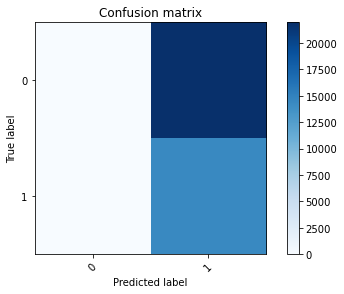

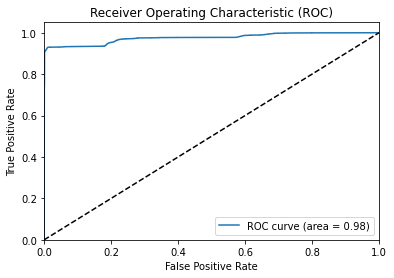

In [23]:
#Best model out of 5 runs
checkpointer = ModelCheckpoint(filepath="dnn/best_tanh_weights.hdf5", verbose=0)
for i in range(5):
    model = Sequential(
        [
            Dense(32, input_dim=x.shape[1], activation='tanh'),
            Dense(12, activation='tanh'),
            Dense(y.shape[1], activation='tanh')
        ]
    )

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=2.5e-3, patience=5,
        verbose=2, mode='auto')
    model.fit(x_train, y_train, validation_data=(x_test, y_test),
        callbacks=[monitor,checkpointer], verbose=0, epochs=200)

print('Model training has completed. Loading best model.')
model.load_weights("dnn/best_tanh_weights.hdf5")

pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print_results(y_true, pred)

pred = model.predict(x_test)[:,1]
plot_roc(pred, y_true)


Series 1, Test 2 - Relu

Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Model training has completed. Loading best model.
              precision    recall  f1-score   support

           0       0.60      1.00      0.75     21938
           1       0.00      0.00      0.00     14459

    accuracy                           0.60     36397
   macro avg       0.30      0.50      0.38     36397
weighted avg       0.36      0.60      0.45     36397

[[21938     0]
 [14459     0]]
Plotting confusion matrix


c:\Users\yyyeeeaaahhh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yyyeeeaaahhh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yyyeeeaaahhh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


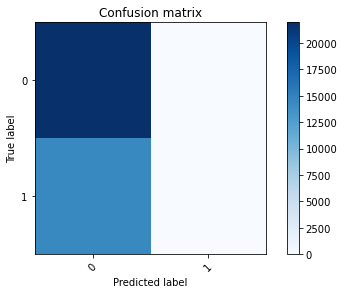

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [28]:
checkpointer = ModelCheckpoint(filepath="dnn/best_relu_weights.hdf5", verbose=0)
for i in range(5):
    model = Sequential(
        [
            Dense(32, input_dim=x.shape[1], activation='relu'),
            Dense(8, activation='relu'),
            Dense(y.shape[1], activation='relu')
        ]
    )

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=2.5e-3, patience=5,
        verbose=2, mode='auto')
    model.fit(x_train, y_train, validation_data=(x_test, y_test),
        callbacks=[monitor,checkpointer], verbose=0, epochs=200)

print('Model training has completed. Loading best model.')
model.load_weights('./dnn/best_relu_weights.hdf5')

pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print_results(y_true, pred)

pred = model.predict(x_test)[:,1]
plot_roc(pred, y_true)

Series 1, Test 3 - Sigmoid

Epoch 00018: early stopping
Epoch 00019: early stopping
Epoch 00020: early stopping
Epoch 00018: early stopping
Epoch 00023: early stopping
Model training has completed. Loading best model.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21938
           1       1.00      1.00      1.00     14459

    accuracy                           1.00     36397
   macro avg       1.00      1.00      1.00     36397
weighted avg       1.00      1.00      1.00     36397

[[21905    33]
 [   50 14409]]
Plotting confusion matrix


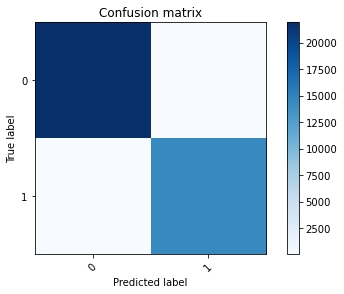

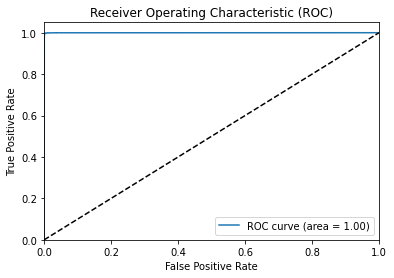

In [26]:
checkpointer = ModelCheckpoint(filepath="dnn/best_sig_weights.hdf5", verbose=0)
for i in range(5):
    model = Sequential(
        [
            Dense(32, input_dim=x.shape[1], activation='sigmoid'),
            Dense(8, activation='sigmoid'),
            Dense(y.shape[1], activation='sigmoid')
        ]
    )

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=2.5e-3, patience=5,
        verbose=2, mode='auto')
    model.fit(x_train, y_train, validation_data=(x_test, y_test),
        callbacks=[monitor,checkpointer], verbose=0, epochs=200)

print('Model training has completed. Loading best model.')
model.load_weights("dnn/best_sig_weights.hdf5")

pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print_results(y_true, pred)

pred = model.predict(x_test)[:,1]
plot_roc(pred, y_true)

##### Test Series 2 - Optimizers, Layers, Neuron Counts.

Series 2, Test 1 - Increase layers and neuron counts.

Epoch 00006: early stopping
Epoch 00009: early stopping
Epoch 00012: early stopping
Epoch 00006: early stopping
Epoch 00006: early stopping
Model training has completed. Loading best model.
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     21938
           1       0.40      1.00      0.57     14459

    accuracy                           0.40     36397
   macro avg       0.20      0.50      0.28     36397
weighted avg       0.16      0.40      0.23     36397

[[    0 21938]
 [    0 14459]]
Plotting confusion matrix


c:\Users\yyyeeeaaahhh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yyyeeeaaahhh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yyyeeeaaahhh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


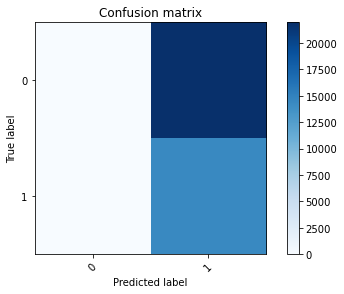

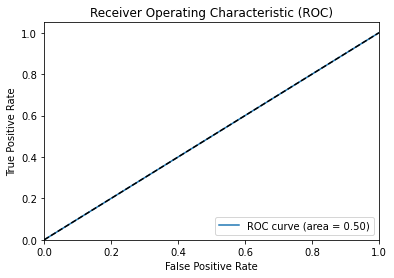

In [34]:
checkpointer = ModelCheckpoint(filepath="dnn/best_tanh_weights2.hdf5", verbose=0)
for i in range(5):
    model = Sequential(
        [
            Dense(128, input_dim=x.shape[1], activation='tanh'),
            Dense(64, activation='tanh'),
            Dense(12, activation='tanh'),
            Dense(y.shape[1], activation='tanh')
        ]
    )

    model.compile(loss='categorical_crossentropy', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=2.5e-3, patience=5,
        verbose=2, mode='auto')
    model.fit(x_train, y_train, validation_data=(x_test, y_test),
        callbacks=[monitor,checkpointer], verbose=0, epochs=200)

print('Model training has completed. Loading best model.')
model.load_weights("dnn/best_tanh_weights2.hdf5")

pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print_results(y_true, pred)

#test
pred = model.predict(x_test)[:,1]
plot_roc(pred, y_true)

Series 2, Test 2 - Reduce neuron count from previous test and attempt to use relu activation in at least one layer.

Epoch 00005: early stopping
Epoch 00006: early stopping
Epoch 00005: early stopping
Epoch 00006: early stopping
Epoch 00006: early stopping
Model training has completed. Loading best model.
              precision    recall  f1-score   support

           0       0.60      1.00      0.75     21938
           1       0.00      0.00      0.00     14459

    accuracy                           0.60     36397
   macro avg       0.30      0.50      0.38     36397
weighted avg       0.36      0.60      0.45     36397

[[21938     0]
 [14459     0]]
Plotting confusion matrix


c:\Users\yyyeeeaaahhh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yyyeeeaaahhh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yyyeeeaaahhh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


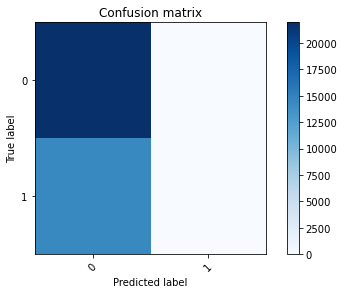

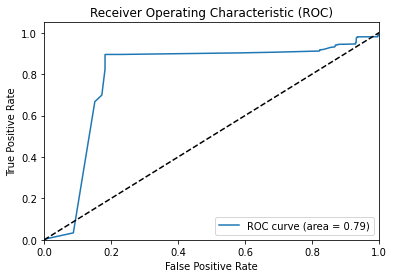

In [54]:
checkpointer = ModelCheckpoint(filepath="dnn/best_tanh_weights3.hdf5", verbose=0)
for i in range(5):
    model = Sequential(
        [
            Dense(48, input_dim=x.shape[1], activation='sigmoid'),
            Dense(16, activation='tanh'),
            Dense(y.shape[1], activation='relu')
        ]
    )

    sgd = optimizers.SGD(lr=0.005, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd)
    monitor = EarlyStopping(monitor='val_loss', min_delta=2.5e-3, patience=5,
        verbose=2, mode='auto')
    model.fit(x_train, y_train, validation_data=(x_test, y_test),
        callbacks=[monitor,checkpointer], verbose=0, epochs=200)

print('Model training has completed. Loading best model.')
model.load_weights("dnn/best_tanh_weights3.hdf5")

pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print_results(y_true, pred)

pred = model.predict(x_test)[:,1]
plot_roc(pred, y_true)